In [ ]:
!pip install esda
!pip install splot


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 882.2/882.2 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.9/389.9 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.7/325.7 kB 26.6 MB/s eta 0:00:00


In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import libpysal
import pandas as pd
from shapely.geometry import Point
from esda import Moran, Moran_Local

#libraries for Moran's I
#from libpysal.weights import Queen,Rook #for polygons
from libpysal .weights import KNN
from esda.moran import Moran

#Library for local Morans I
from esda.moran import Moran_Local

In [ ]:
# ----------------
# 1. Load dataset
# ----------------
gdf = gpd.read_file("/content/Panamaram_Soil_Samples_cliped.shp")
gdf = gdf.to_crs(epsg=4326)

/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:198: RuntimeWarning: Value '.00000000000      0' of field Panamaram_Soil_Samples_cliped.K parsed incompletely to real 0.
  return ogr_read(
/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:198: RuntimeWarning: Value 'IRULAM' of field Panamaram_Soil_Samples_cliped.Zn parsed incompletely to real 0.
  return ogr_read(
/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:198: RuntimeWarning: Value 'Garden land' of field Panamaram_Soil_Samples_cliped.Field31 parsed incompletely to real 0.
  return ogr_read(
/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:198: RuntimeWarning: Value 'M' of field Panamaram_Soil_Samples_cliped.Field31 parsed incompletely to real 0.
  return ogr_read(
/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:198: RuntimeWarning: Value 'Wet land' of field Panamaram_Soil_Samples_cliped.Field31 parsed incompletely to real 0.
  return ogr_read(
/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:1

In [ ]:
# List the columns that contain the non-numeric values based on the error messages.
columns_to_clean = ['K', 'Zn', 'P', 'Field31', 'Field32']

# Loop through each column and convert the data to a numeric type.
# The 'errors='coerce'' argument will replace any non-numeric values with NaN.
for col in columns_to_clean:
    gdf[col] = pd.to_numeric(gdf[col], errors='coerce')

# Now, you have a few options for handling the NaN (missing) values:

# OPTION 1: Drop rows with any NaN values in the specified columns.
# This is a simple and effective method if you have a large enough dataset.
gdf_cleaned = gdf.dropna(subset=columns_to_clean)
print("Shape of original data:", gdf.shape)
print("Shape of cleaned data after dropping rows:", gdf_cleaned.shape)

Shape of original data: (2871, 36)
Shape of cleaned data after dropping rows: (535, 36)


<Axes: >

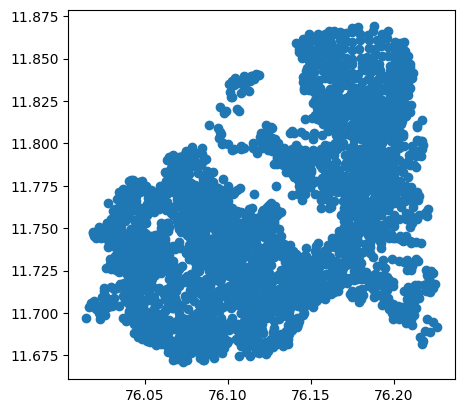

In [ ]:
gdf.plot()

In [ ]:
print(gdf.columns)  # check available columns

# Choose a variable to test spatial autocorrelation
variable='pH'

Index(['Sl_No', 'District', 'Block', 'Panchayat', 'Village', 'cadastral_',
       'survey_no', 'Latitude', 'Longitude', 'farmer_nam', 'Date_sampl',
       'sample_cod', 'pH', 'EC', 'Org__C', 'P', 'K', 'Ca', 'Mg', 'S', 'Fe',
       'Mn', 'Zn', 'Cu', 'B', 'Texture', 'Landuse', 'crop', 'Land_use',
       'Field30', 'Field31', 'Field32', 'Field29', 'Field8', 'Field9',
       'geometry'],
      dtype='object')


In [ ]:
# Convert the variable column to numeric, coercing errors
gdf[variable] = pd.to_numeric(gdf[variable], errors='coerce')

# Drop rows with NaN values in Latitude or Longitude for spatial weights
gdf_cleaned = gdf.dropna(subset=['Latitude', 'Longitude', variable])

In [ ]:
# ----------------
# 2. Spatial weights (Queen contiguity)
# ----------------
# Using KNN weights as used in previous cells since Queen contiguity is for polygons and this is point data
w = libpysal.weights.KNN.from_dataframe(gdf_cleaned, k=4)
w.transform = 'r'  # row-standardize


/usr/local/lib/python3.12/dist-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


In [ ]:
# 3. Global Moran's I
# ----------------
mi = Moran(gdf_cleaned[variable], w)
print("Global Moran's I:", mi.I)
print("p-value:", mi.p_sim)

Global Moran's I: 0.053680844085047544
p-value: 0.024


In [ ]:
# ----------------
# 4. Local Moran's I
# ----------------
lisa = Moran_Local(gdf_cleaned[variable], w)

/usr/local/lib/python3.12/dist-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.12/dist-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/usr/local/lib/python3.12/dist-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

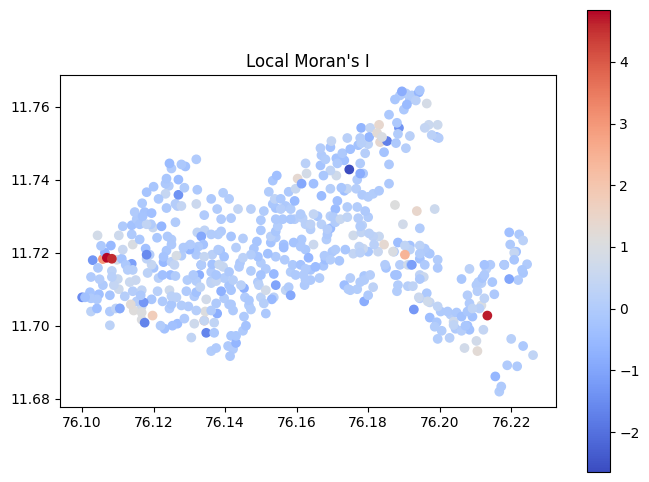

In [ ]:
# Add results to GeoDataFrame
gdf_cleaned["Local_I"] = lisa.Is
gdf_cleaned["p_val"] = lisa.p_sim
gdf_cleaned["Cluster"] = lisa.q

# ----------------
# 5. Plot results
# ----------------
# Global result
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
gdf_cleaned.plot(column="Local_I", cmap="coolwarm", legend=True, ax=ax)
plt.title("Local Moran's I")
plt.show()

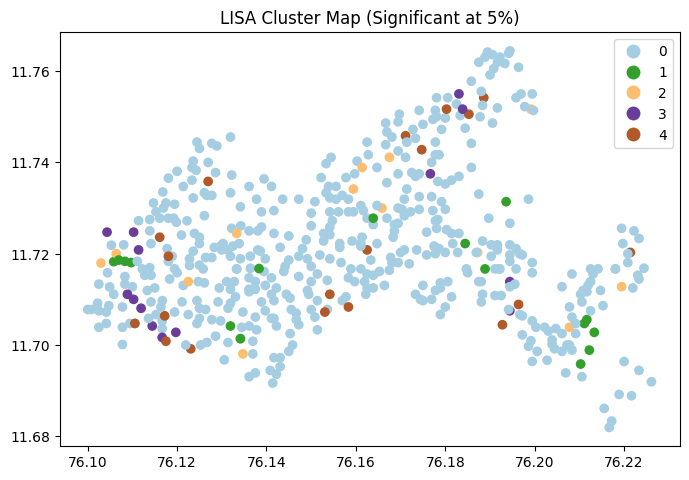

In [ ]:
# Cluster map (HH, LL, HL, LH)
sig = 1 * (lisa.p_sim < 0.05)
hotspots = sig * lisa.q

gdf_cleaned.assign(cl=hotspots).plot(column='cl', categorical=True, legend=True,
                             cmap='Paired', figsize=(8,6))
plt.title("LISA Cluster Map (Significant at 5%)")
plt.show()

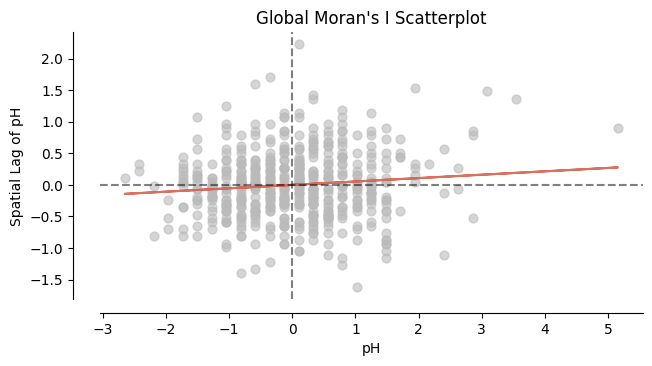

In [ ]:
from splot.esda import moran_scatterplot
import matplotlib.pyplot as plt

# Plot Global Moran's I scatterplot
fig, ax = moran_scatterplot(mi)
ax.set_xlabel(variable)
ax.set_ylabel(f'Spatial Lag of {variable}')
plt.title('Global Moran\'s I Scatterplot')
plt.show()